In [1]:
# %%
import numpy as np
import pandas as pd
import sys
import os
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from src.spore_tree_config import SporeTreeConfig
from src.spore_tree import SporeTree
from src.pendulum import PendulumSystem
from src.visualize_spore_tree import visualize_spore_tree
from src.area_opt.tree_area_evaluator import TreeAreaEvaluator

In [4]:
def draw_rk(pendulum, state, time_sign, control, N = 50, total_dt=0.01):
    poses = [state]

    for i in range(1, N+1):
        poses.append(pendulum.step(poses[-1], control, time_sign*total_dt/N*i))

    return np.array(poses)

In [5]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.1,
    max_control=2.0
)

init_position = np.array([np.pi/3  , 0])

cfg = SporeTreeConfig(
    initial_position=init_position,
    dt_base=0.02,
    dt_grandchildren_factor=0.1,
    figure_size=(10, 10)
)
cfg.validate()

True

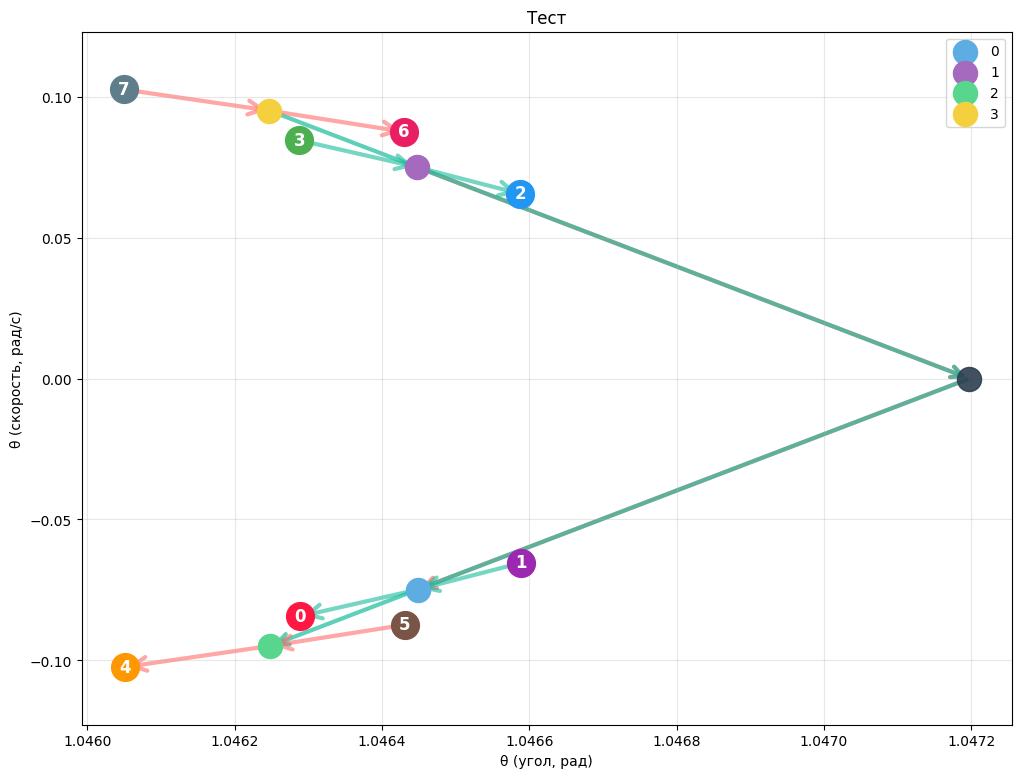

In [6]:
tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")


poses = []
# dts = [0.01, 0.005, 0.003, 0.003, 0.01, 0.006, 0.003, 0.003]
dts = [0.0001, 0.001, 0.001, 0.00, 0.00, 0.001, 0.001, 0.000] 
dts = np.array(dts) 

for i in range(len(grandchildren)):
    parent_pos = children[grandchildren[i]['parent_idx']]['position']
    sign = grandchildren[i]['dt'] / grandchildren[i]['dt_abs']
    control = grandchildren[i]['control']
    poses_1 = draw_rk(pendulum, state=parent_pos, time_sign=sign, control=control, total_dt=dts[i])
    if dts[i] > 0:
        # plt.plot(poses_1[:, 0], poses_1[:, 1], label=f'{i}')
        pass

plt.legend()


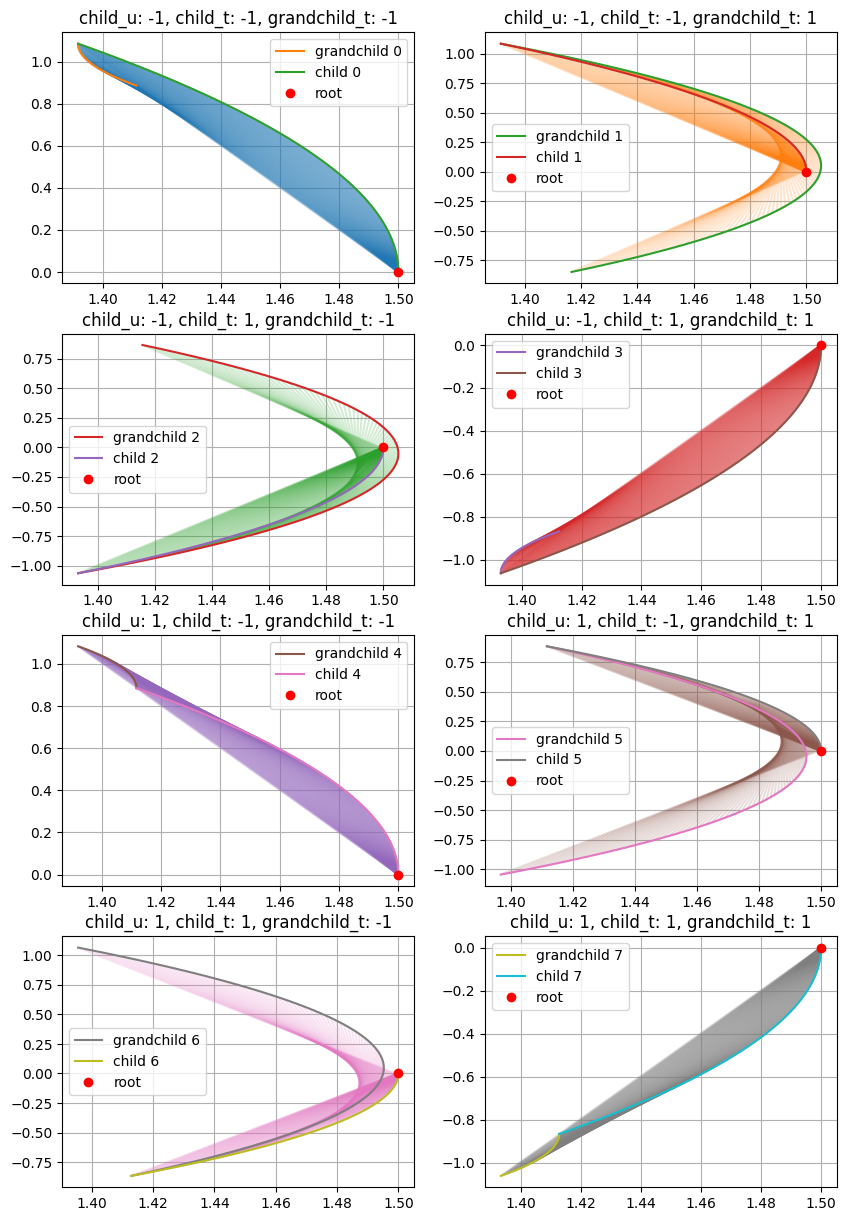

In [7]:
import itertools as it

root_pos = np.array([1.5, 0])
u_abs = 2
N = 100
T = 0.2
dt_1 = np.linspace(T/N, T, N)
dt_2 = T - dt_1

children = []
grandchildren = []

plt.figure(figsize=(10, 15))

for i, comb in enumerate(it.product([-1, 1], repeat=3)):
    child_u_sign, child_t_sign, grandchild_t_sign = comb
    
    u1_sign = child_u_sign
    t1_sign = child_t_sign
    u2_sign = -child_u_sign
    t2_sign = grandchild_t_sign

    grandchild_poses = []
    child_poses = []
    plt.subplot(4, 2, i+1)
    plt.title(f'child_u: {child_u_sign}, child_t: {child_t_sign}, grandchild_t: {grandchild_t_sign}')
    for j in range(len(dt_1)):
        pos_1 = pendulum.step(root_pos, u1_sign*u_abs, t1_sign*dt_1[j])
        pos_2 = pendulum.step(   pos_1, u2_sign*u_abs, t2_sign*dt_2[j])

        child_poses.append(pos_1)
        grandchild_poses.append(pos_2)

        tip = np.vstack([root_pos, pos_1, pos_2])
        plt.plot(tip[:, 0], tip[:, 1], color=f'C{i}', alpha=0.2)
    grandchild_poses = np.array(grandchild_poses)
    child_poses = np.array(child_poses)


    grandchildren.append(grandchild_poses)
    children.append(child_poses)

    plt.plot(grandchild_poses[:, 0], grandchild_poses[:, 1], 
            label=f'grandchild {i}', 
            color=f'C{i+1}', 
            alpha=1)

    plt.plot(child_poses[:, 0], 
            child_poses[:, 1],  
            label=f'child {i}', 
            color=f'C{i+2}', 
            alpha=1)

    plt.plot(root_pos[0], root_pos[1], 'ro', label='root')
    plt.legend()
    plt.grid()


        


In [8]:
gc_inds = (0, 5, 4)

for child_id in list(set([i for i in gc_inds])):
    plt.plot(children[child_id][:, 0], children[child_id][:, 1], 
            label=f'child {child_id}',  
            alpha=1)

for grandchild_id in gc_inds:
    plt.plot(grandchildren[grandchild_id][:, 0], grandchildren[grandchild_id][:, 1], 
            label=f'grandchild {grandchild_id}', 
            alpha=1)



plt.legend()
plt.grid()

In [39]:
root_pos = np.array([1.5, 0])

T = 0.1
N = 10
u_abs = 1

t_combs = list(it.product(np.linspace(0, T, N), repeat=2))

children = []
grandchildren = []
border_grandchildren = []

plt.figure(figsize=(10, 15))
for i, comb in enumerate(it.product([-1, 1], repeat=3)):
    # print(i)
    # print(comb)
    child_u_sign, child_t_sign, grandchild_t_sign = comb

    
    u1_sign = child_u_sign
    t1_sign = child_t_sign
    u2_sign = -child_u_sign
    t2_sign = grandchild_t_sign

    poses_1 = []
    poses_2 = []
    poses_2_border = []
    for t_comb in t_combs:
        t1, t2 = t_comb
        # print(t1,t2)

        pos_1 = pendulum.step(root_pos, u1_sign*u_abs, t1_sign * t1)
        pos_2 = pendulum.step(   pos_1, u2_sign*u_abs, t2_sign * t2)

        poses_1.append(pos_1)
        poses_2.append(pos_2)

        if abs(t2) < 0.000001:
            poses_2_border.append(pos_2)
            

    poses_1 = np.array(poses_1)
    poses_2 = np.array(poses_2)
    poses_2_border = np.array(poses_2_border)

    # print(comb)
    grandchildren.append(poses_2)
    plt.subplot(4, 2, i+1)
    plt.title(str(i))
    plt.plot(root_pos[0], root_pos[1], 'o', color=f'C{i+2}', label='root')
    plt.plot(poses_2[:, 0], poses_2[:, 1], '.', color=f'C{i+1}', alpha=0.25, label='grandchild')
    plt.plot(poses_1[:, 0], poses_1[:, 1], '.', color=f'C{i}', alpha=0.5, label='child')
    plt.plot(poses_2_border[:, 0], poses_2_border[:, 1], '.', color=f'C{i+2}', alpha=0.5, label='grandchild border')
    plt.legend()
    plt.grid()


In [10]:
import numpy as np
import alphashape
from shapely.geometry import MultiPolygon, Polygon
from shapely.ops import unary_union

def concave_hull(points: np.ndarray, alpha: float):
    """
    points: (N,2) массив точек
    alpha: параметр 'облипании' (меньше -> извилистее)
    return: объект Shapely (Polygon или MultiPolygon)
    """
    geom = alphashape.alphashape(points, alpha)
    # На всякий случай починим возможные самопересечения
    if not geom.is_valid:
        geom = geom.buffer(0)
    return geom

def intersection_of_concave_hulls(pointsA, pointsB, alphaA=1.0, alphaB=1.0):
    hullA = concave_hull(pointsA, alphaA)
    hullB = concave_hull(pointsB, alphaB)
    inter = hullA.intersection(hullB)
    # Нормализуем результат к списку полигонов
    if inter.is_empty:
        return []
    if isinstance(inter, Polygon):
        return [inter]
    if isinstance(inter, MultiPolygon):
        return list(inter.geoms)
    # На случай сложных результатов (полилинии/точки) — отфильтруем только полигоны
    return [g for g in getattr(inter, "geoms", []) if isinstance(g, Polygon)]


AttributeError: 'MultiPolygon' object has no attribute 'exterior'

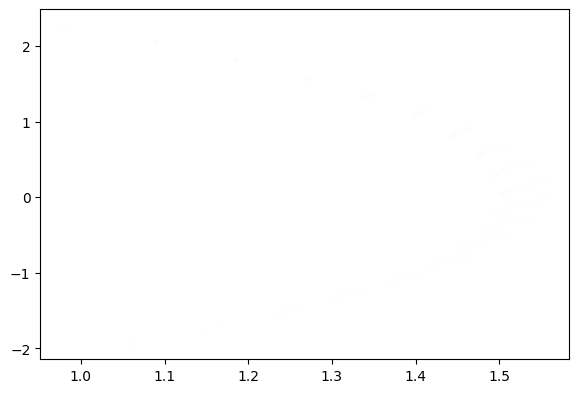

In [11]:
pairs = [(1, 2), (0, 4), (6, 5), (3, 7)]

plt.figure(figsize=(15, 10))
for i, pair in enumerate(pairs[:1]):
    plt.subplot(2, np.ceil(len(pairs) / 2).astype(int), i + 1)
    for j in pair:
        
        plt.plot(grandchildren[j][:, 0], grandchildren[j][:, 1], 
                '.',
                label=f'grandchild {j}',
                alpha=0.005)
        alpha = 1
        shape = alphashape.alphashape(grandchildren[j], alpha)
        plt.fill(shape.exterior.xy[0], shape.exterior.xy[1], 
                alpha=0.2)
            
        plt.plot(*shape.exterior.xy, alpha=0.6)

    plt.legend()
    plt.grid()

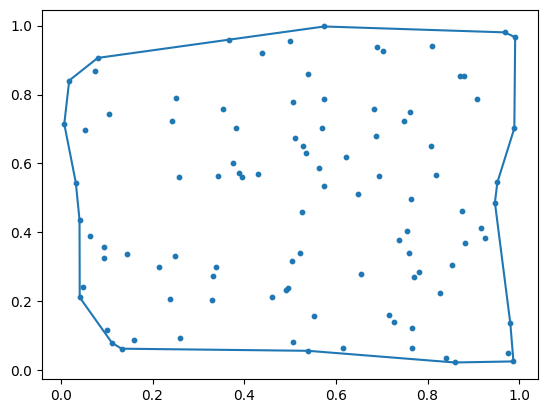

In [ ]:
import alphashape
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np

# Примерные точки
points = np.random.rand(100, 2)

# alpha — параметр "гладкости"
alpha = 1.5  
shape = alphashape.alphashape(points, alpha)

# Визуализация
plt.scatter(points[:,0], points[:,1], s=10)
plt.plot(*shape.exterior.xy)
plt.show()
